In [1]:
# Change the directory to the Tables folder
TABLE_DIR = '../Tables/'
FIG_DIR = '../Figures/'
FIG_DIR_0125 = '../Figures/new/[0, 1, 2, 5]/'

In [3]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
import seaborn as sns

In [5]:
from utils import *

This notebook comparesthe "global" approach for imputing missing observations with the "local approach". The difference is that the global approach uses data of all models, but the local approach only uses those with the selected four base models. We show that the local approach performs better. This is not surprising, because we already observe in the main paper that the principle component space of the full matrix is different from that of the selected submatrix.

In [6]:
# Base models that we will look at
frequent_base_models_new = ['llama-3.1-8b', 'qwen2.5-14b', 'qwen2.5-7b', 'qwen2.5-0.5b', 'mistral-7b', 'gemma-2-9b']
# Benchmarks included in the leaderboard
cols_to_transform_new = ['IFEval', 'BBH', 'MATH Lvl 5', 'GPQA', 'MUSR', 'MMLU-PRO']
# Load the leaderboard
df_filtered_new = pd.read_csv(TABLE_DIR + 'open_llm_leaderboard_with_token_size.csv')

model_names = [frequent_base_models_new[i] for i in [0, 1, 2, 5]]
X = df_filtered_new[cols_to_transform_new].values
X_subset = select_data(df_filtered_new, cols_to_transform_new, model_names)

We use the k-nearest neighbor algorithm to perform matrix completion.

In [7]:
np.random.seed(2025)

n_rows, n_cols = X.shape

M = 1000 # Repeat the experiment M times

global_rmse_list = []
local_rmse_list = []

for m in range(M):

  # --- Step 1: Generate and mask the data matrix ---

  random_matrix = np.random.rand(n_rows, n_cols)

  # Create a boolean mask where 'True' means the element is *not* masked (observed)
  mask = random_matrix > 0.95


  # Create the masked matrix (using np.nan for missing entries)
  X_masked = X.copy()
  X_masked[~mask] = np.nan

  # --- Step 2: Define a subset of rows ---
  subset_indices = choose_subset_indices(df_filtered_new, model_names)

  # --- KNN Matrix Completion Function ---
  def knn_matrix_completion(X_incomplete, n_neighbors=5):
      """
      Complete the matrix using k-nearest neighbors imputation.

      Parameters:
          X_incomplete: 2D numpy array with np.nan at missing entries.
          n_neighbors: Number of neighbors to use for imputation.

      Returns:
          X_completed: Completed matrix.
      """
      imputer = KNNImputer(n_neighbors=n_neighbors)
      X_completed = imputer.fit_transform(X_incomplete)
      return X_completed

  # --- Approach 1: Global Completion using KNN ---
  X_completed_global = knn_matrix_completion(X_masked)

  # --- Approach 2: Local Completion on the subset using KNN ---
  # Extract the submatrix corresponding to the subset indices.
  X_subset_masked = X_masked[subset_indices, :]
  X_completed_local = knn_matrix_completion(X_subset_masked)

  # --- Step 3: Evaluate Performance ---
  # Compute the MSE on the missing entries in the submatrix.

  # For the global completion, extract the corresponding rows.
  global_missing = ~mask[subset_indices, :]
  global_errors = (X[subset_indices, :][global_missing] - X_completed_global[subset_indices, :][global_missing]) ** 2
  global_mse = np.nanmean(global_errors)

  # For the local completion, compare the imputed submatrix with the true values.
  local_missing = ~mask[subset_indices, :]
  local_errors = (X[subset_indices, :][local_missing] - X_completed_local[local_missing]) ** 2
  local_mse = np.nanmean(local_errors)

  global_rmse_list.append(global_mse ** 0.5)
  local_rmse_list.append(local_mse ** 0.5)

Compare the RMSE of the global and local approach.

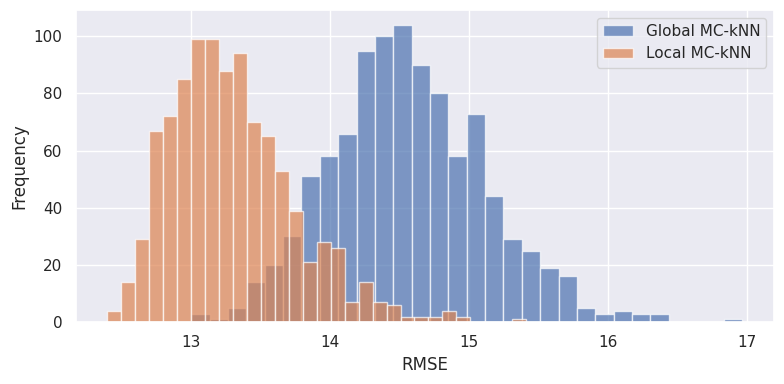

In [10]:
# Set a seaborn style (optional but recommended)
sns.set_theme()

# Choose a seaborn color palette
sns.set_palette("deep") # other options are: muted, pastel, bright, dark, colorblind, tab10, tab20

plt.figure(figsize=(8, 4))
plt.hist(global_rmse_list, bins=30, alpha=0.7, label='Global MC-kNN')
plt.hist(local_rmse_list, bins=30, alpha=0.7, label='Local MC-kNN')
plt.xlabel('RMSE', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
# plt.title('Distribution of RMSE for Global and Local Matrix Completion')
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR + 'rmse_global_local.png')